# XGBoost Regression

### Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from xgboost import XGBRegressor as xgbreg
from xgboost import plot_importance

### Import Data

In [2]:
RawData = pd.read_csv('SampleData_XGBoost.csv')
Data = RawData.dropna()
Data

,SAMPLE#,PLANT_DENSITY,FERTILIZER,SEED_HYBRID,NDVI,BIOMASS,PNU,YIELD
0,1,35,100,HYB1,0.868,6.09,74.1762,181.879349
1,3,34,200,HYB1,0.924,7.92,125.4528,218.899751
2,4,34,100,HYB1,0.840,5.64,63.6192,168.532993
3,7,31,50,HYB1,0.700,3.31,21.9122,131.016787
4,9,31,50,HYB1,0.728,3.28,21.5168,134.711135
...,...,...,...,...,...,...,...,...
495,491,35,175,HYB2,0.882,5.94,70.5672,240.757991
496,492,34,175,HYB2,0.868,5.35,57.2450,231.871162
497,495,34,0,HYB2,0.644,1.89,7.1442,46.544353
498,497,34,175,HYB2,0.910,7.03,98.8418,221.592631


### Convert Variety to One-Hot Encoding

In [3]:
VarietiesOneHot = pd.get_dummies(Data.SEED_HYBRID)
Data = pd.concat([Data, VarietiesOneHot], axis=1)
Data

,SAMPLE#,PLANT_DENSITY,FERTILIZER,SEED_HYBRID,NDVI,BIOMASS,PNU,YIELD,HYB1,HYB2
0,1,35,100,HYB1,0.868,6.09,74.1762,181.879349,1,0
1,3,34,200,HYB1,0.924,7.92,125.4528,218.899751,1,0
2,4,34,100,HYB1,0.840,5.64,63.6192,168.532993,1,0
3,7,31,50,HYB1,0.700,3.31,21.9122,131.016787,1,0
4,9,31,50,HYB1,0.728,3.28,21.5168,134.711135,1,0
...,...,...,...,...,...,...,...,...,...,...
495,491,35,175,HYB2,0.882,5.94,70.5672,240.757991,0,1
496,492,34,175,HYB2,0.868,5.35,57.2450,231.871162,0,1
497,495,34,0,HYB2,0.644,1.89,7.1442,46.544353,0,1
498,497,34,175,HYB2,0.910,7.03,98.8418,221.592631,0,1


### Define Variables

In [4]:
# Response Variables ['NDVI','PLANT_DENSITY','FERTILIZER']
X = Data[['NDVI','FERTILIZER','PLANT_DENSITY','HYB1','HYB2']]

# Predicted Variable ['BIOMASS' or 'YIELD']
y = Data[['BIOMASS']]

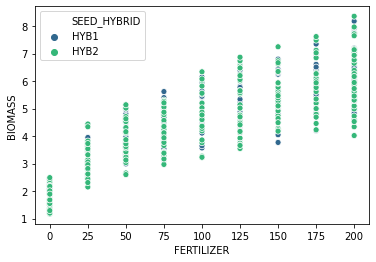

In [5]:
sns.scatterplot(data=Data, x='FERTILIZER', y='BIOMASS',hue='SEED_HYBRID',palette='viridis')

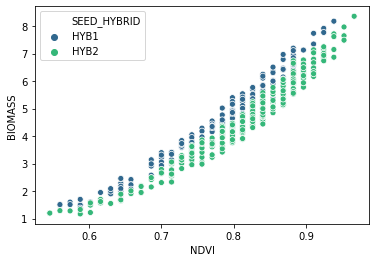

In [6]:
sns.scatterplot(data=Data, x='NDVI', y='BIOMASS',hue='SEED_HYBRID',palette='viridis')

### Split Into Testing and Training Sets

In [7]:
# Method 1 - Choose Training and Testing Groups by Category (i.e. experimental replicate, block, etc)

# Train = Data.loc[(Data['Block']!=1)&(Data['Block']!=4)]
# Test = Data.loc[(Data['Block']==1)|(Data['Block']==4)]
#X_train = Train[['FERTILIZER','NDVI','PLANT_DENSITY']]
#y_train = Train[['BIOMASS']]
#X_test = Test[['FERTILIZER','NDVI','PLANT_DENSITY']]
#y_test = Test[['BIOMASS']]

# Method 2 - Choose Training and Testing Randomly by Splitting 67% Training / 33% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [8]:
# Convert into DMatrix which is the dataframe used for XGBoost
DMatrix_train = xgb.DMatrix(X_train,y_train)
DMatrix_test = xgb.DMatrix(X_test, y_test)

### Define Regression Parmeters

In [9]:
def optimizer(DMatrix_train):
    #Setting to Default Values
    params = {'min_child_weight':1, 'max_depth': 6}
    best = 100
    boost = 1
    min_child_wt = 1
    depth = 1
    learningrate = 0
    #Searching for optimal max_depth and min_child_weight using nested for loop to search all input ranges
    for max_depth in range(2,6,1):
        for min_child_weight in range(1,6,1):
            for eta in np.arange(0.0,0.8,0.05):
                params['max_depth'] = max_depth
                params['min_child_weight'] = min_child_weight
                params['learning_rate'] = eta
                # Run Cross-Validation to Tune Model Parameters
                results = xgb.cv(dtrain = DMatrix_train, params = params, nfold=3,num_boost_round=10000, early_stopping_rounds=3, metrics="mae",seed=123)
                # Update best MAE
                MAE = results['test-mae-mean'].min()
                boost_rounds = results['test-mae-mean'].argmin()
                if MAE < best:
                    depth = max_depth
                    boost = boost_rounds
                    learningrate = eta
                    min_child_wt = min_child_weight
                    best = MAE
                
    print("The mae on test set: {:.4f}".format(best))
    print("Boosting Rounds: {:.4f}".format(boost))
    print("min_child_weight: {:.4f}".format(min_child_wt))
    print("max depth: {:.4f}".format(depth))
    print("learning rate{:.4f}".format(learningrate))

In [10]:
optimizer(DMatrix_train)

The mae on test set: 0.2413
Boosting Rounds: 52.0000
min_child_weight: 4.0000
max depth: 2.0000
learning rate0.3000


In [11]:
# Sample Output from hyperTune()
# The mae on test set: 0.1580
# Boosting Rounds: 84.0000
# min_child_weight: 1.0000
# max depth: 4.0000
# learning rate: 0.0500

In [12]:
params = {'min_child_weight': 4,
          'max_depth': 2,
         'learning_rate': 0.3}

### Fit Training Set and Show Statistics

In [13]:
xg_reg = xgbreg(**params)
xg_reg.fit(X_train, y_train.values.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=2,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Cross Validation

In [14]:
# Training
rmse = (mean_squared_error(y_train, xg_reg.predict(X_train))**0.5)  
print("The RMSE on train set: {:.4f}".format(rmse))
r2 = r2_score(y_train, xg_reg.predict(X_train))
print("The r2 on train set: {:.4f}".format(r2))
mae = mean_absolute_error(y_train, xg_reg.predict(X_train))
print("The MAE on train set: {:.4f}".format(mae))

The RMSE on train set: 0.2427
The r2 on train set: 0.9743
The MAE on train set: 0.1953


In [15]:
# Testing
rmse = (mean_squared_error(y_test, xg_reg.predict(X_test))**0.5)  
print("The RMSE on test set: {:.4f}".format(rmse))
r2 = r2_score(y_test, xg_reg.predict(X_test))
print("The r2 on test set: {:.4f}".format(r2))
mae = mean_absolute_error(y_test, xg_reg.predict(X_test))
print("The MAE on test set: {:.4f}".format(mae))

The RMSE on test set: 0.2647
The r2 on test set: 0.9676
The MAE on test set: 0.2045


In [16]:
feature_imp = pd.Series(xg_reg.feature_importances_,index=list(X_train)).sort_values(ascending=False)
feature_imp

NDVI             0.689514
FERTILIZER       0.213599
HYB1             0.093532
PLANT_DENSITY    0.003355
HYB2             0.000000
dtype: float32

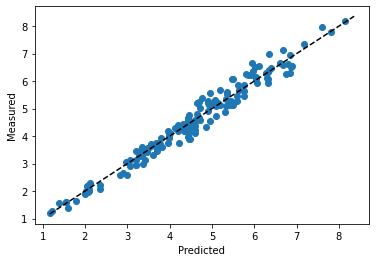

In [17]:
# Plot for PNU
x_pred = xg_reg.predict(X_test)
plt.scatter(x_pred,y_test)
plt.xlabel('Predicted')
plt.ylabel('Measured')

# Find min and max values of measured variable and plot abline to show correlation of training and testing models (i.e. biomass, yield, PNU, etc.)
miny=y.min()
maxy=y.max()
abline = np.linspace(miny,maxy)
plt.plot(abline,abline,'--k')


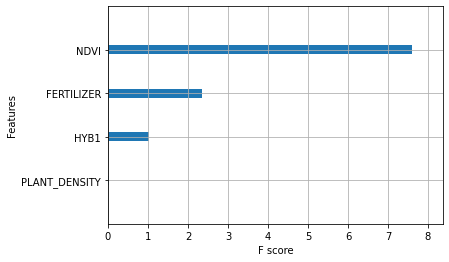

In [18]:
plot_importance(xg_reg,importance_type='gain',show_values=False,title=None)

# NDVI most important followed by Fertilizer and Seed Hybrid. Plant Density did not rank as important.